In [7]:
from collections import defaultdict
import pandas as pd
import numpy as np
import timesfm
import multiprocessing

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.distributions import (Normal, NegativeBinomial, StudentT, Poisson)
import argparse
import os
import time
import math
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.itertools import batcher
from utils.utils import load_test_data
from utils.data_loader import create_cached_tsmixup_datasets
from load_cached_features import *
from timesfm.pytorch_patched_decoder import ResidualBlock
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import stdtrit
# from utils.utils import load_test_data
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 33  # batch size: any positive integer
TEST = 100  # test set length: any positive integer
context_len = 512
pred_len = 128
device = 'cuda:3'

In [2]:
# Loading tsmixup dataset
train_dataset, val_dataset = create_cached_tsmixup_datasets(
        max_samples=300000,
        context_length=512,
        prediction_length=96, # 1 or 96
        num_workers=16,
        cache_dir="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/",
        processed_cache_path="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl",
        batch_size=4000
    )

def load_dataset(dataset, ts=1000, pred_length=1, ctx_len=512):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'])
            y.append(val_dict['future_values'])
        x = torch.stack(x)[:, -ctx_len:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
        x = torch.stack(x)

    if dataset != 'tsmixup':
        y = x[:,ctx_len:ctx_len+pred_length]
        x = x[:,:ctx_len]
    return x, y

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend='gpu',
        per_core_batch_size=64,
        context_len=context_len,  # currently max supported
        horizon_len=pred_len,  # number of steps to predict
        input_patch_len=32,  # fixed parameters
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
        point_forecast_mode='mean',
        device=device,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

🚀 CREATING CACHED TSMIXUP DATASETS
📂 Found existing processed data at /extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl
⚡ Loading preprocessed data from cache...
✅ Loaded 174,209 preprocessed samples
📅 Cache created: 2025-08-03 15:05:17

📊 DATASET SUMMARY:
  Total processed samples: 174,209
  Context length: 512
  Prediction length: 96
🔀 Shuffling data...
📈 Data split:
  Training samples: 156,788
  Validation samples: 17,421
  Train ratio: 90.0%
🏗️  Creating PyTorch datasets...
🏗️  Dataset created with 156,788 samples
📊 Augmentation: ON
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2043, mean=1320
  Value ranges: min=-49.2103, max=70.9532
  Value stats: mean=0.9038, std=2.2952
🏗️  Dataset created with 17,421 samples
📊 Augmentation: OFF
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2048, mean=1284
  Value ranges: min=-28.6077, max=79.0030
  Value

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# Load Training Dataset
train_ds = FullLatentShardDataset("./data/timesfm_cache_last_fp16/last_shard_*.pt")

In [27]:
def get_mask(latents: Tensor, labels: Tensor, max_val: int):
    nan_mask = ~torch.isfinite(latents)
    max_mask = labels > max_val # [B, H]
    mask = ~torch.any(nan_mask, dim=1) | torch.any(max_mask, dim=1)
    return mask

def get_preds(model: torch.nn.Module, latents: Tensor, horizon_len: int = 96, output_dims: int = 1):
    out = model(latents)  # [B, horizon_len * output_dims]
    b, _ = out.shape
    out = out.view(b, horizon_len, output_dims)  # [B, H, D]
    return out

def get_batch(dataset: torch.utils.data.Dataset, batch_num: int, batch_size: int, device: str):
    latents, stats, labels = [], [], []
    for i in range(batch_size):
        dataset_ind = batch_num + i
        latent, stat, label = dataset[dataset_ind]
        latents.append(latent)
        stats.append(stat)
        labels.append(label)
    latents = torch.stack(latents).to(device).float()
    stats   = torch.stack(stats).to(device)
    labels  = torch.stack(labels).to(device)
    return latents, stats, labels

def latent_forecast(pred_head: torch.nn.Module, latents: Tensor, horizon_len: int, head_type: str, 
                    output_dims: int | None = None, labels: Tensor | None = None, 
                    mu0: Tensor | None = None, sigma0: Tensor | None = None,
                    q_low: float = 0.1, q_high: float = 0.9, forecast: bool = True):
    results = {}
    if output_dims == None:
        output_dims_dict = {"mse": 1, "gaussian": 2, "poisson": 1, "neg_binom": 2, "studentst": 1}
        output_dims = output_dims_dict[head_type]
    
    out = get_preds(pred_head, latents, horizon_len, output_dims) # [B, H, D]
    if head_type == "mse":
        pred = out[:, :, 0] # [B, H]
        if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
            pred = pred * sigma0[:, None] + mu0[:, None]
        if torch.is_tensor(labels):
            loss = F.mse_loss(pred, labels)
            results["loss"] = loss
        if forecast:
            results["mean"] = pred.detach().cpu()
            results["median"] = pred.detach().cpu()
    else: # distribution loss
        if head_type == "gaussian":
            pred_mu = out[:, :, 0]
            pred_std = F.softplus(out[:, :, 1]) + 1e-6
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_mu = pred_mu * sigma0[:, None] + mu0[:, None]
                pred_std = pred_std * sigma0[:, None]
            distribution = Normal(pred_mu, pred_std)
        elif head_type == "poisson":
            pred_lambda = F.softplus(out[:, :, 0]) + 1e-6
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_lambda = pred_lambda * sigma0[:, None] + mu0[:, None]
            distribution = Poisson(pred_lambda)
        elif head_type == "neg_binom":
            pred_successes = F.softplus(out[:, :, 0]) + 1e-6
            pred_p = F.sigmoid(out[:, :, 1])
            distribution = NegativeBinomial(pred_successes, pred_p)
        elif head_type == "studentst":
            pred_df = F.softplus(out[:, :, 0]) + 1e-6
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                distribution = StudentT(pred_df, loc=mu0[:, None] * torch.ones_like(pred_df), 
                                        scale=sigma0[:, None] * torch.ones_like(pred_df))
            else:
                distribution = StudentT(pred_df)
        else:
            raise KeyError(f"{head_type} is not a valid distribution or loss")
        if torch.is_tensor(labels):
            loss = -distribution.log_prob(labels).mean()
            results["loss"] = loss
        if forecast:
            results["mean"] = distribution.mean.detach().cpu()
            if head_type == "studentst":
                p = torch.tensor([0.5, q_low, q_high])[:, None, None] * torch.ones((3, out.shape[0], out.shape[1]))
                preds = stdtrit(pred_df.detach().cpu().repeat(3, 1, 1), p)
                results["median"] = preds[0]
                results["q_low"] = preds[1]
                results["q_high"] = preds[2]
            else:
                results["median"] = distribution.icdf(0.5*torch.ones_like(out[:,:,0])).detach().cpu()
                results["q_low"] = distribution.icdf(q_low*torch.ones_like(out[:,:,0])).detach().cpu()
                results["q_high"] = distribution.icdf(q_high*torch.ones_like(out[:,:,0])).detach().cpu()

    return results
            


In [19]:
# Standard Head
head_type = "studentst"
patch_len = 32
hidden_size = 1280
intermediate_size = 1280
output_dims = 1
horizon_len = 96
tot_iters = 2097152
batch_size = 512
output_dims_dict = {"mse": 1, "gaussian": 2, "poisson": 1, "neg_binom": 2, "studentst": 1}
output_dims = output_dims_dict[head_type]

pred_head = ResidualBlock(
        input_dims=hidden_size,
        output_dims=horizon_len*output_dims,
        hidden_dims=intermediate_size,
    ).to(device).train()
save_path = f"models/timesfm_{head_type}_head.pt"

# pred_head = torch.nn.Linear(hidden_size, horizon_len*output_dims).to(device).train()

optimizer = torch.optim.AdamW(pred_head.parameters(), lr=3e-4, weight_decay=1e-2)
grad_clip = 1.0
scaler = torch.amp.GradScaler()

logvar_min, logvar_max = -10.0, 10.0              # normalized log-variance bounds
sigma_floor, sigma_ceiling = 1e-6, 1e6            # per-sample sigma bounds in original units
var_floor, var_ceiling = 1e-12, 1e12              # final variance bounds
min_std_norm = 0.05                               # floor on normalized std (pre sigma scaling)
max_label = 1000                                  # If Label is greater remove as an outlier

training_loss = []
tfm_loss = []
run_tfm = False

In [ ]:
# Training setup
loss_batch = []
tfm_loss_batch = []
for epoch in tqdm(range(3), desc="Epochs", disable=True):
    pbar = tqdm(range(0, tot_iters, batch_size), desc=f"Epoch: {epoch}", leave=True)
    for batch_num in pbar:
        latents, stats, labels = get_batch(train_ds, batch_num, batch_size, device)
        mask = get_mask(latents, labels, max_label)

        if torch.any(mask == 0):
            latents = latents[mask]
            stats = stats[mask]
            labels = labels[mask]
            # print(f"Reduced batch_size from {batch_size} to {latents.shape[0]}")

        # Set up norm
        mu0    = stats[:, 0].float()                                # [B]
        sigma0 = stats[:, 1].float()                                # [B]
        labels_norm = (labels.float() - mu0[:, None]) / sigma0[:, None]       # [B, H]

        optimizer.zero_grad(set_to_none=True)

        results = latent_forecast(pred_head, latents, horizon_len, head_type, 
                    output_dims, labels=labels_norm, forecast=False)
        loss = results["loss"]
        loss_batch.append(loss.item())

        # Backward with AMP
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(pred_head.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        if run_tfm:
            with torch.no_grad():            
                output_ts = tfm._model.horizon_ff_layer(latents)
                b, _ = output_ts.shape
                output_ts = output_ts.view(b, 128, 10)[:, :horizon_len, 0]
                tfm_loss_batch.append(F.mse_loss(output_ts, labels_norm).item())

        # print(f"isfinite: latents {torch.isfinite(latents).all()} count: {torch.count_nonzero(torch.logical_not(torch.isfinite(latents)))}")
        # print(f"isfinite: mu_pred {torch.isfinite(mu_pred).all()}, min {mu_pred.min():.2e} max {mu_pred.max():.2e} q(0.999) {torch.quantile(mu_pred, 0.999):.2e}")
        # print(f"isfinite: y {torch.isfinite(y).all()}, min {y.min():.2e} max {y.max():.2e} q(0.999) {torch.quantile(y, 0.999):.2e}")
        # print(f"isfinite: labels {torch.isfinite(labels).all()}, min {labels.min():.2e} max {labels.max():.2e} q(0.999) {torch.quantile(labels, 0.999):.2e}")
        # print(f"isfinite: sigma {torch.isfinite(sigma).all()}, min {sigma.min():.2e} max {sigma.max():.2e} q(0.999) {torch.quantile(sigma, 0.999):.2e}")
        
        # Logging
        if batch_num % (batch_size * 1024) == 0:
            train_med_loss = np.median(np.array(loss_batch))
            loss_batch = []
            pbar.set_description(f"epoch: {epoch} batch_num: {batch_num // batch_size}/{tot_iters // batch_size} loss: {train_med_loss:.4f}") 
            # print(f"epoch: {epoch} batch_num: {batch_num // batch_size} loss: {train_med_loss:.4f}")
            training_loss.append(train_med_loss)
            if run_tfm:
                tfm_med_loss = np.median(np.array(tfm_loss_batch))
                tfm_loss_batch = []
                print(f"TimesFM mse: {tfm_med_loss:.4f}")
                tfm_loss.append(tfm_med_loss)

torch.save(pred_head.state_dict(), save_path)

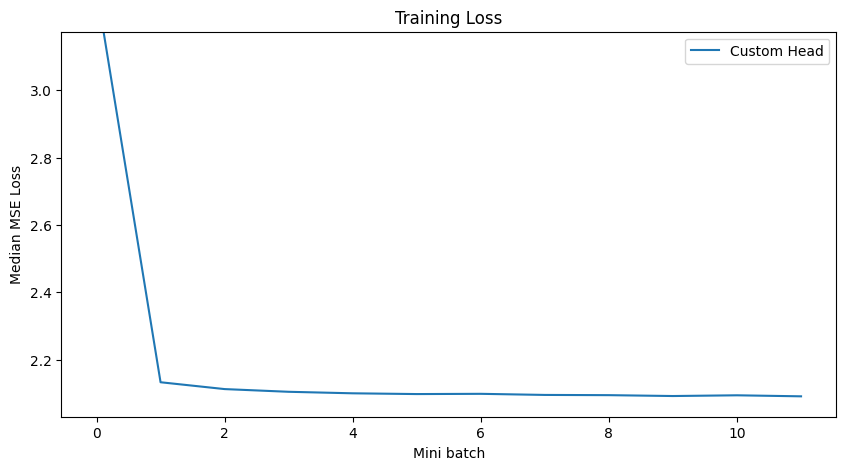

In [13]:
# Plot Training Loss
plt.figure(figsize=(10,5))
plt.plot(training_loss, label="Custom Head")
if run_tfm:
    plt.plot(tfm_loss, label="Timesfm")
plt.legend()
plt.xlabel("Mini batch")
plt.ylabel("Median MSE Loss")
plt.title("Training Loss")
plt.ylim(top=np.quantile(training_loss, 0.99))
plt.show()

tensor([0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037,
        0.5037, 0.5037, 0.5037, 0.5037, 0.5037, 0.5037])
tensor([7.5426e-17, 7.5753e-17, 7.5599e-17, 7.5679e-17, 7.5506e-17, 7.4623e-17,
        7.5102e-17, 7.6628e-17, 7.8123e-17, 7.6904e-17, 7.7354e

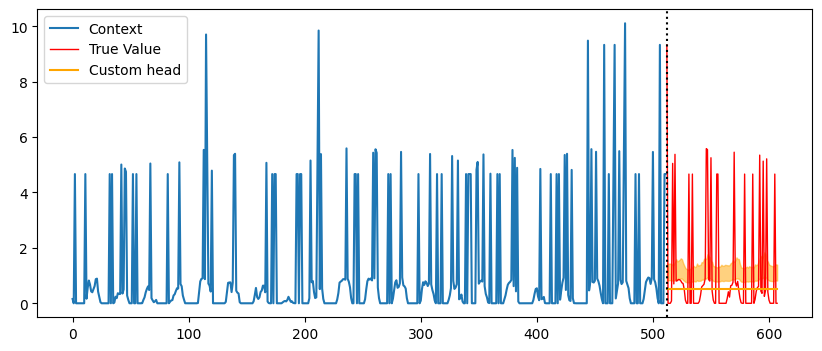

In [ ]:
# Plot Examples
pred_head.load_state_dict(torch.load(save_path))
x, y = load_dataset('tsmixup', 100, pred_length=horizon_len, ctx_len=context_len)
# Load Latents
tfm_pred, tfm_quantiles, (latents, stats) = tfm.forecast(x, get_stacked_transformer=True)
latents = latents[:, -1, :].to(device)

mu0    = stats[:, 0].float()                                # [B]
sigma0 = stats[:, 1].float()
results = latent_forecast(pred_head, latents, horizon_len, head_type, 
                          output_dims, mu0=mu0, sigma0=sigma0, 
                          q_high=0.9, q_low=0.1)
head_pred = results["mean"]
head_q10 = results["q_low"] 
head_q90 = results["q_high"]

ind = 4
print(head_pred[ind])
print(results["median"][ind])
print(mu0[ind])
plt.figure(figsize=(10,4))
plt.plot(x[ind], label="Context")
plt.plot(np.arange(y.shape[1]) + context_len, y[ind].detach().cpu(), color='red', label='True Value', lw=1)

# plt.plot(np.arange(tfm_pred.shape[1]) + context_len, tfm_pred[ind], color='green', label='TimesFM')
# plt.fill_between(np.arange(tfm_pred.shape[1]) + context_len, tfm_quantiles[ind, :, 1], tfm_quantiles[ind, :, -1], color='green', alpha=0.5)
plt.plot(np.arange(head_pred.shape[1]) + context_len, head_pred[ind].detach().cpu(), color='orange', label='Custom head')
plt.fill_between(np.arange(head_pred.shape[1]) + context_len, head_q10[ind], head_q90[ind], color='orange', alpha=0.5)

plt.axvline(context_len, color="black", ls=':')
plt.legend()
plt.show()